In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from os import listdir
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.applications import imagenet_utils
from keras.models import load_model
from keras.applications import VGG16

Using TensorFlow backend.


In [16]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = load_img(image_path, target_size=(224, 224))
    # Convert PIL image to numpy array of 3-dimensions
    x = img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [17]:
# Load the inception v3 model
model = VGG16(weights='imagenet')

In [18]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [19]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image,verbose=0) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [20]:
file=open('all_train_captions.txt','r')
all_train_captions=file.read().split('\n')

In [21]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 5
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 2530


In [22]:
wordtoix= load(open('w2i.pkl','rb'))
ixtoword= load(open('i2w.pkl','rb'))

In [23]:
model=load_model('VGG16_models/403.h5')

In [24]:
images = 'Flickr8k_Dataset/'

In [25]:
# Call the funtion to encode all the train images
def encoding_input(img):
    print('[INFO]: Input image encoding....')
    encoding_input = {}
    encoding_input = encode(img)
    print('[INFO]: Input image encoded :D')

    return encoding_input


In [26]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(34):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=34)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

[INFO]: Input image encoding....
[INFO]: Input image encoded :D


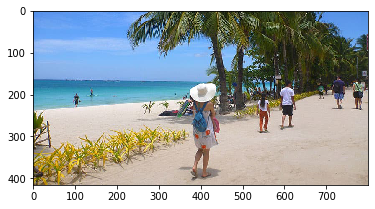

Greedy: group of people are standing on the beach


In [27]:
img='10.jpg'
image = encoding_input(img).reshape((1,4096))
x=plt.imread(img)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))